## Testing σ-irregularity vs. total σ-irregularity

### Problem Definition
We are given two measures of a graph irregularity,
*σ-irregularity* and *total σ-irregularity*, defined as bellow:<br /><br />
$$
\sigma(G) = \sum_{(u,v) \in E(G)}(d(u) - d(v))^2 
\quad\text{and}\quad 
\sigma_t(G) = \sum_{(u,v) \in V(G)}(d(u) - d(v))^2
$$.<br />
We are searching for graphs, where the ratio's
$r_{\sigma} = \sigma_t(G)\thinspace/\thinspace\sigma(G)$ 
maximum is reached.

### Basic Environment Settings

In [11]:
import warnings
warnings.filterwarnings('ignore')

from math import inf
import matplotlib.pyplot as plt

def defaultPlotTemplate(title, xlab, ylab):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    return ax

class Bcol:
    HEADER = '\033[95m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    GOLD = '\033[93m'
    FAIL = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    ENDC = '\033[0m'

NNODES = 40
NSIMUL = 200
NTESTS = 100

### Smaller Graphs
For smaller graphs we will use the brute-force approach and test all the possibilites. We found an online database for all non-isomorphic, connected graphs on up to $11$ vertices, therefore this is what we will use, though the files for $10$ and $11$ vertices are too large so we will go up to $9$.

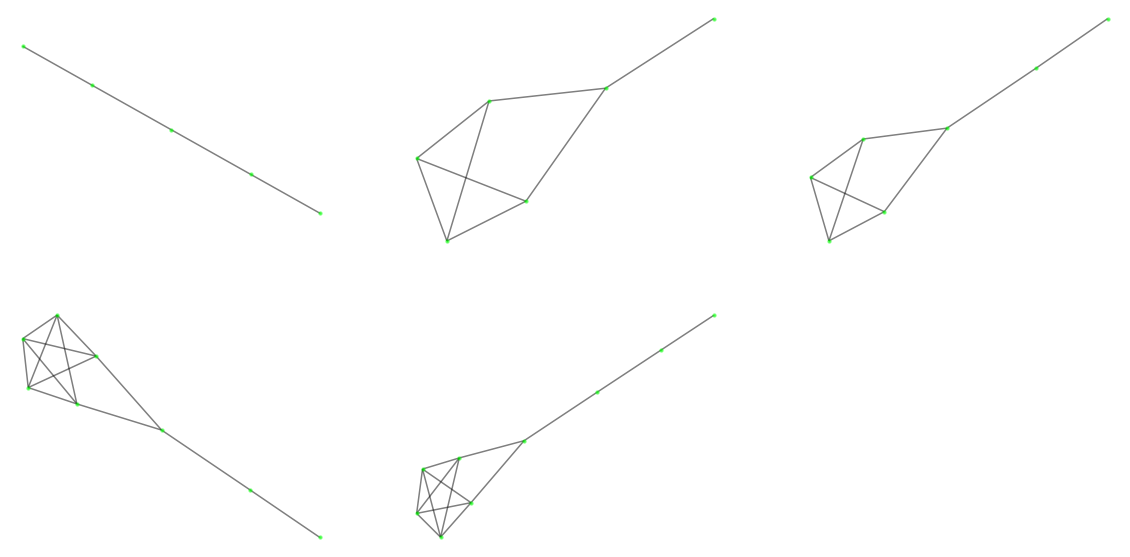

In [2]:
from pathlib import Path
import networkx as nx
from pylib import sigmaRatio_nx, simpleSubplot

files = Path().cwd() / 'g6data'
pairs = []
for file in files.iterdir():
    if file.suffix != '.g6': continue
    Gn = nx.read_graph6(file)
    pair = [0,0]
    for G in Gn:
        r = sigmaRatio_nx(G)
        if r > pair[0]:
            pair = [r, G]
    pairs.append(pair)
    
simpleSubplot(list(zip(*pairs))[1])

### Solution Implementation

We will use simulated annealing algorithm to attack this problem and have written a library that will help us with the general implementation. 
The main idea was using the algorithm to find a global optimum (the graph that maximizes $\sigma_r$) by making global changes at every step and then fix the acquired graph by fixing it with some mild local changes.

Lets try running the algorithm on 20 nodes with 200 simulations made and by choosing a *globalBasicNeighbor* topology, which defines the neighbor pretty much as a random connected graph on 20 vertices.

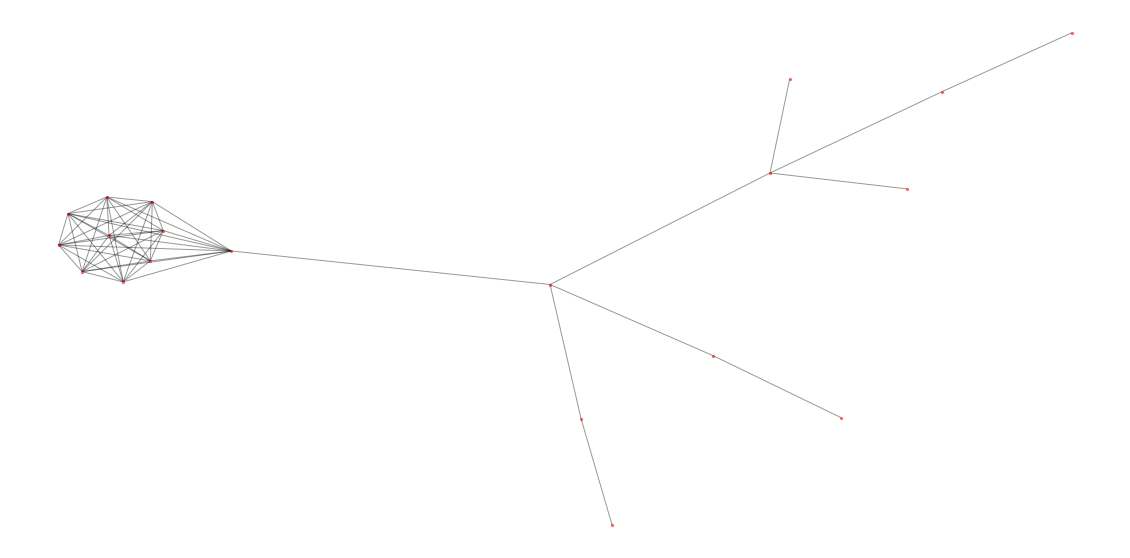

Sigma Ratio: 70.0


In [27]:
from pylib import (
    maxSigmaRatio_annealing, globalBasicNeighbor,
    simplePlot, neighborListToNx
)

g, r = maxSigmaRatio_annealing(
    20, 100, 200, globalBasicNeighbor
)

simplePlot(neighborListToNx(g))
print(Bcol.BLUE + 'Sigma Ratio:' + Bcol.ENDC, Bcol.GOLD + str(r) + Bcol.ENDC)

We noticed a pattern here early on, which is the two-parted nature of optimal graphs, so we adjusted the neighborhood topology for optimization purposes. Lets try out another topology.

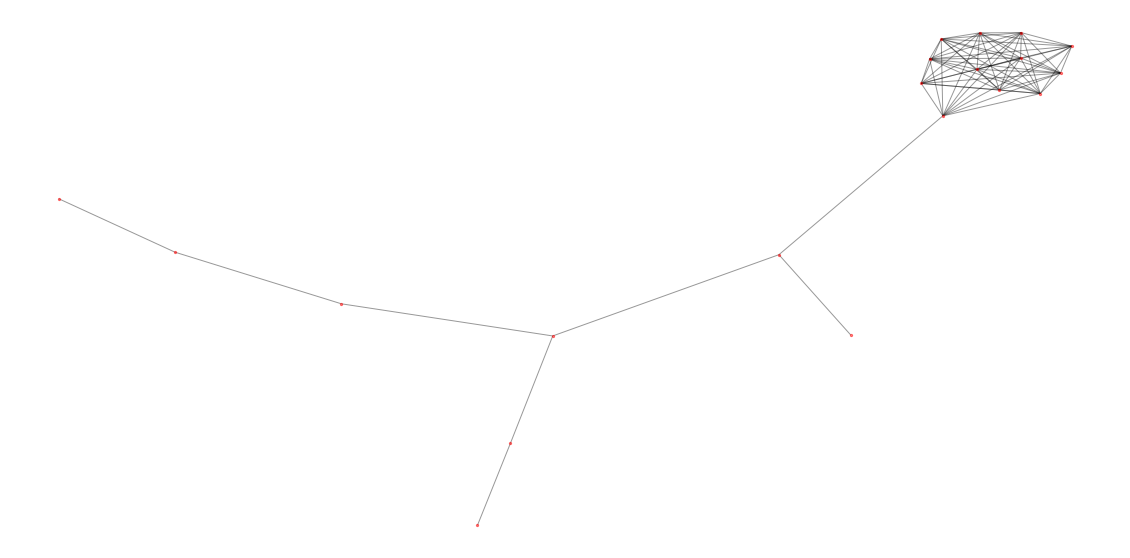

Sigma Ratio: 78.61224489795919


In [28]:
from pylib import globalTwoPartNeighbor

g, r = maxSigmaRatio_annealing(
    20, 100, 200, globalTwoPartNeighbor
)

simplePlot(neighborListToNx(g))
print(Bcol.BLUE + 'Sigma Ratio:' + Bcol.ENDC, Bcol.GOLD + str(r) + Bcol.ENDC)

Now we've covered the global part, but we still can find a slightly better optimum, by applying some local changes, like trying to smooth the difference between the degree of nodes forming a bridge between a full subgraph and the tree-like subgraph. This is implemented in the function *localBasicNeighbor*.

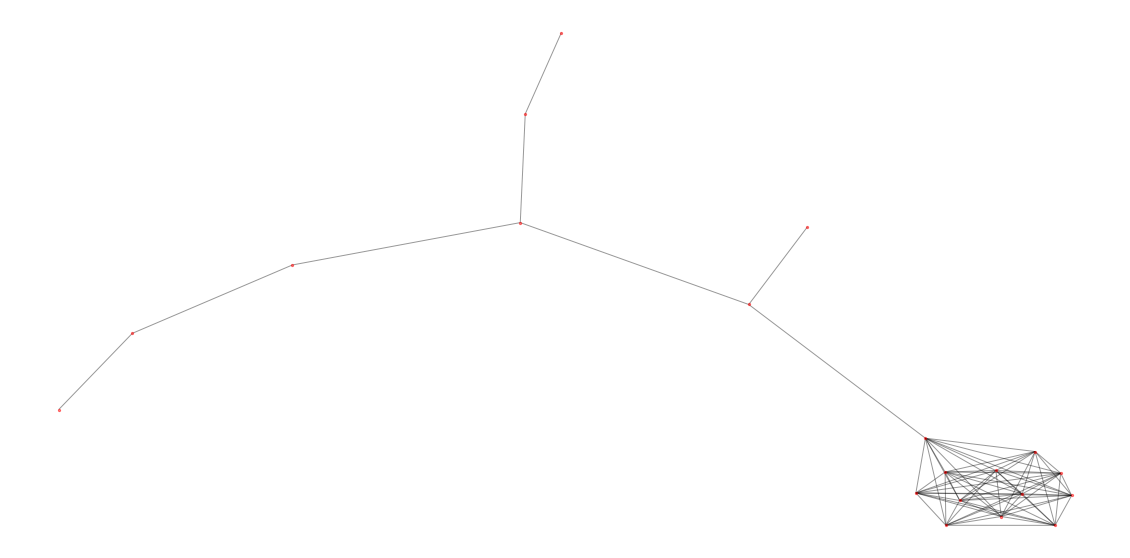

Sigma Ratio: 78.61224489795919


In [29]:
from pylib import localBasicNeighbor

g, r = maxSigmaRatio_annealing(
    20, 100, 200, localBasicNeighbor,
    defaultG = g
)

simplePlot(neighborListToNx(g))
print(Bcol.BLUE + 'Sigma Ratio:' + Bcol.ENDC, Bcol.GOLD + str(r) + Bcol.ENDC)

The next step is to see how the optimal graph's $\sigma_r$ value progresses when its order rises.
We will graph the resulting $\sigma_r$ values using *matplotlib* as we did before implicitly.
But first lets gather the data.

In [8]:
nsim_global, nsim_local = 200, 20
index, ascend = [], []
node_range = range(3, 100)
for i in node_range:
    startedges = i * (i - 1) // 2
    g, r = maxSigmaRatio_annealing(
        i, startedges, nsim_global,
        globalTwoPartNeighbor
    )
    g, r = maxSigmaRatio_annealing(
        i, startedges, nsim_local,
        localBasicNeighbor
    )
    ascend.append(r)

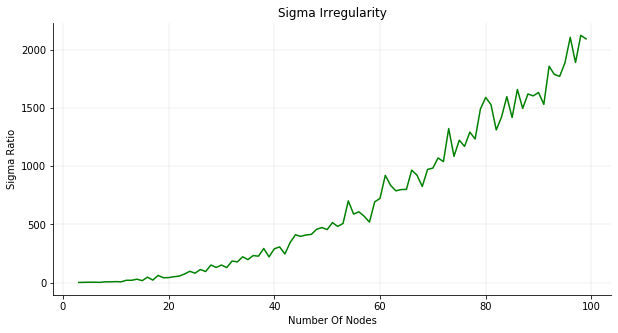

In [9]:
ax = defaultPlotTemplate('Sigma Irregularity', 'Number Of Nodes', 'Sigma Ratio')
ax.plot(node_range, ascend, 'g')
plt.show()

We now have some sense of what is happening with the $\sigma_r$ values, but our task is also to find real values $c$ and $p$ for which $cn^p$ best aproximates $\sigma_r(G_n)$. 
We will implement this using the *largest squares method*, which for given $p$ lets us find the best aproximation $c$ explicitly.

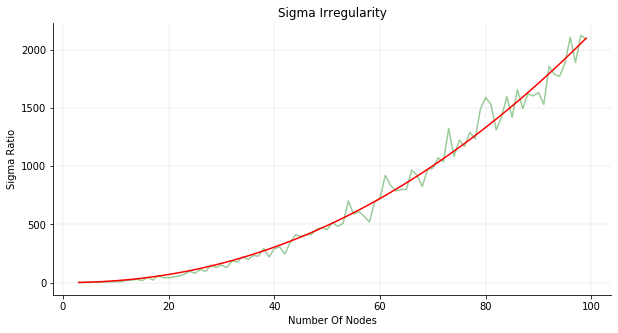

Optimal power: 2.13
Optimal constant: 0.11786639721454727
Optimal difference: 710.4703382152825


In [10]:
from pylib import squares

opt_diff, opt_c, opt_p = inf, 0, 0
for p in (i / 100 for i in range(400)):
    x = [pow(i, p) for i in node_range]
    c, d = squares(x, ascend)
    if d < opt_diff:
        opt_diff, opt_c, opt_p = d, c, p

ax = defaultPlotTemplate('Sigma Irregularity', 'Number Of Nodes', 'Sigma Ratio')
ax.plot(node_range, ascend, 'g', alpha=0.4)
ax.plot(node_range, [opt_c * pow(i, opt_p) for i in node_range], 'r')
plt.show()

print(f'{Bcol.BLUE}Optimal power:{Bcol.ENDC}', Bcol.GREEN + str(opt_p) + Bcol.ENDC)
print(f'{Bcol.BLUE}Optimal constant:{Bcol.ENDC}', Bcol.GREEN + str(opt_c) + Bcol.ENDC)
print(f'{Bcol.BLUE}Optimal difference:{Bcol.ENDC}', Bcol.GREEN + str(opt_diff) + Bcol.ENDC)

We can also read a file which we made after running SA algorithm on nodes up to 700.

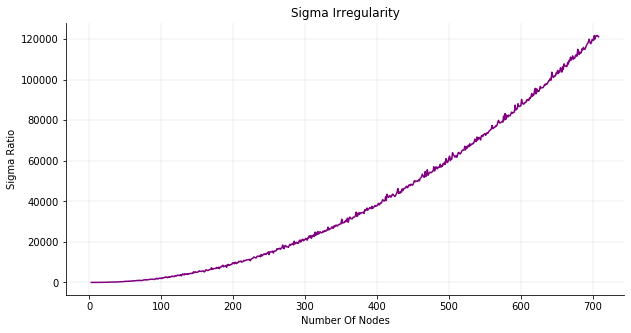

In [17]:
import json

with open('data.json', 'r') as file:
    data = json.load(file)
    
node_range = range(3, 3 + len(data))
ax = defaultPlotTemplate('Sigma Irregularity', 'Number Of Nodes', 'Sigma Ratio')
ax.plot(node_range, data, 'purple')
plt.show()

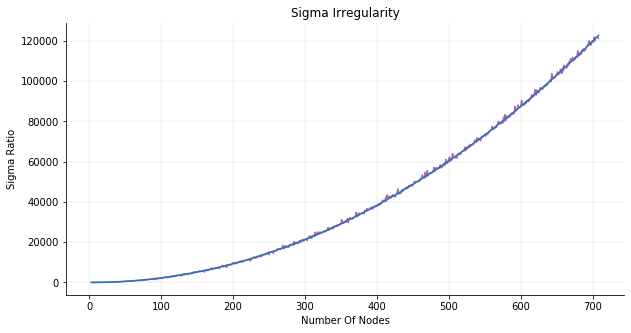

Optimal power: 2.037999999999965
Optimal constant: 0.19075292631871665
Optimal dispersion: 16048.328007397437


In [23]:
from pylib import powerAproximation

opt_diff, opt_c, opt_p = powerAproximation(data, 1, 4, 1000, node_range)
ax = defaultPlotTemplate('Sigma Irregularity', 'Number Of Nodes', 'Sigma Ratio')
ax.plot(node_range, data, 'purple', alpha=0.6)
ax.plot(node_range, [opt_c * pow(i, opt_p) for i in node_range], '')
plt.show()

print(f'{Bcol.BLUE}Optimal power:{Bcol.ENDC}', Bcol.GREEN + str(opt_p) + Bcol.ENDC)
print(f'{Bcol.BLUE}Optimal constant:{Bcol.ENDC}', Bcol.GREEN + str(opt_c) + Bcol.ENDC)
print(f'{Bcol.BLUE}Optimal deviation:{Bcol.ENDC}', Bcol.GREEN + str(opt_diff) + Bcol.ENDC)

After seeing this it really seems that the deviation is falling and the values get better aproximated by $n^2$.